In [27]:
# Import all necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.datasets import load_digits
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

import timeit
from timeit import default_timer as timer
import os
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Load data
df = pd.read_csv("heart_disease_dataframe.csv")

**Data Inspection**

In [5]:
# Load first five rows

print("The first five rows:")
print(df.head(5))

The first five rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [7]:
# Print the dimensions of the dataframe with shape()
print("Dataframe dimensions:")
print(df.shape) # inspect dimensions of the df

Dataframe dimensions:
(303, 14)


In [9]:
# Check for missing values for each feature
print("Null value count for each feature:")
print(df.isnull().sum()) # show number of missing values in each column

Null value count for each feature:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [11]:
# Since no NA values were identfied, explore further for unusual values
# Check the number of unique values for each feature
print("Number of unique values for each feature:")
print(df.nunique().sort_values()) 

Number of unique values for each feature:
sex           2
fbs           2
exang         2
target        2
restecg       3
slope         3
cp            4
thal          4
ca            5
oldpeak      40
age          41
trestbps     50
thalach      91
chol        152
dtype: int64


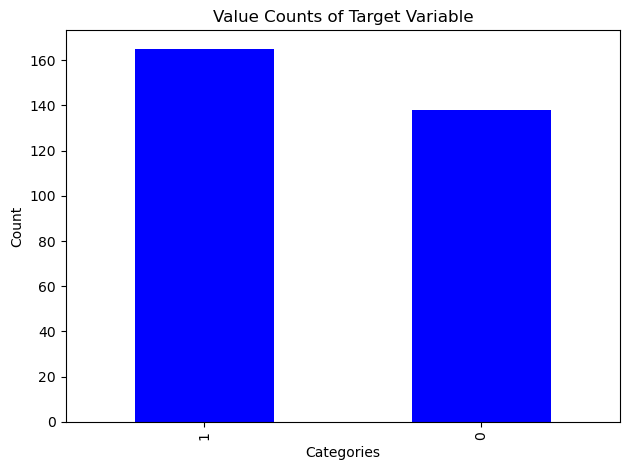

In [13]:
# Plot the distribution of values in the target feature
counts = df['target'].value_counts()
counts.plot(kind='bar', color='blue')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Value Counts of Target Variable')
plt.tight_layout()
plt.show()

**Data Cleaning and Preparation**

In [15]:
# Set necessary variables to "NA"
# for "ca" variable, NA values are denoted in the data as 4, 
  # since values should only be  0,1,2,3 as specified in the documentation
# for "thal" variable, NA values are denoted as O since values are from 1-3
  # as specified in the documentation

df.loc[df["ca"] == 4, "ca"] = pd.NA

df.loc[df["thal"] == 0, "thal"] = pd.NA

In [17]:
# Drop rows that have an NA value
df = df.dropna()

In [19]:
# Split into X and y 
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [21]:
# Split into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(237, 13) (60, 13) (237,) (60,)


In [31]:
# Check information gain of all variables
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X_encoded[col])

# Compute information gain
i_scores = mutual_info_classif(X, y)

# Create a DataFrame to view scores
info_gain = pd.Series(i_scores, index=X.columns).sort_values(ascending=False)
print(info_gain)

ca          0.168856
thal        0.151349
exang       0.119518
oldpeak     0.105728
cp          0.086175
thalach     0.078578
chol        0.075927
slope       0.066450
sex         0.053453
restecg     0.024446
fbs         0.021515
age         0.001924
trestbps    0.000000
dtype: float64


**Model Development**

In [33]:
# Need to transform and scale variables for modelling
# Scale numerical variables
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# Encode cateogrical variables with one hot encoder
categorical_features = ['cp', 'sex', 'fbs', 'restecg', 'exang', 'slope']
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [35]:
# Count the total number of features after one hot encoding
X_transformed = preprocessor.fit_transform(X_train)

# Get the shape of the transformed data
print("Number of features after preprocessing:", X_transformed.shape[1])

Number of features after preprocessing: 23


In [37]:
# Make Naive Bayes pipeline
NBpipe = Pipeline(steps=[
    ('preprocessor', preprocessor), # Preprocess the features
    ('nb', GaussianNB()) # Include option to try different types of NB
])

param_grid_NB = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()], 
     'nb': [GaussianNB(), BernoulliNB()]
}

In [39]:
# Perform grid search to test all parameters

grid_search_NB = GridSearchCV(NBpipe, param_grid=param_grid_NB, cv=10, verbose=1, n_jobs = -1)
start = timer()
grid_search_NB.fit(X_train, y_train)
end = timer()
print(end - start)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
7.643267299979925


In [41]:
# Print best combination of parameters
grid_search_NB.best_params_

{'nb': BernoulliNB(), 'preprocessor__num__scaler': StandardScaler()}

In [43]:
scores_df_NB = pd.DataFrame(grid_search_NB.cv_results_)
scores_df_NB = scores_df_NB.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df_NB

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb,param_preprocessor__num__scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.040616,0.019564,0.014977,0.002322,BernoulliNB(),StandardScaler(),"{'nb': BernoulliNB(), 'preprocessor__num__scal...",0.916667,0.833333,0.916667,0.875000,0.708333,0.750000,0.833333,0.782609,0.782609,0.782609,0.818116,0.066029,1
1,0.027167,0.009582,0.013641,0.002258,BernoulliNB(),MinMaxScaler(),"{'nb': BernoulliNB(), 'preprocessor__num__scal...",0.833333,0.750000,0.916667,0.875000,0.791667,0.791667,0.750000,0.826087,0.739130,0.739130,0.801268,0.057932,2
2,0.029242,0.004522,0.013293,0.001206,GaussianNB(),StandardScaler(),"{'nb': GaussianNB(), 'preprocessor__num__scale...",0.875000,0.791667,0.833333,0.958333,0.708333,0.708333,0.791667,0.782609,0.695652,0.695652,0.784058,0.082637,3
3,0.025201,0.002812,0.014205,0.001377,GaussianNB(),MinMaxScaler(),"{'nb': GaussianNB(), 'preprocessor__num__scale...",0.875000,0.791667,0.833333,0.958333,0.708333,0.666667,0.791667,0.782609,0.695652,0.695652,0.779891,0.087270,4


In [45]:
# kNN pipeline
kNNpipe  = Pipeline(steps=[
    ('preprocessor', preprocessor), # feature preprocessor
    ('kNN', KNeighborsClassifier())
])

param_grid_kNN = {
    'preprocessor__num__scaler':[StandardScaler(), MinMaxScaler(),'passthrough'], 
    'kNN__n_neighbors':[5, 10, 30],
    'kNN__weights':['uniform', 'distance']
}

In [47]:
# Perform grid search
grid_search_kNN = GridSearchCV(kNNpipe, param_grid=param_grid_kNN, cv=10, verbose=1, n_jobs = -1)
start = timer()
grid_search_kNN.fit(X_train, y_train)
end = timer()
print(end - start)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
1.8598260000580922


In [49]:
# Print best combination of parameters
grid_search_kNN.best_params_

{'kNN__n_neighbors': 5,
 'kNN__weights': 'uniform',
 'preprocessor__num__scaler': StandardScaler()}

In [51]:
# Print scores for all combinations of parameters
scores_df_kNN = pd.DataFrame(grid_search_kNN.cv_results_)
scores_df_kNN = scores_df_kNN.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df_kNN

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kNN__n_neighbors,param_kNN__weights,param_preprocessor__num__scaler,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.026435,0.008368,0.228611,0.162379,5,uniform,StandardScaler(),"{'kNN__n_neighbors': 5, 'kNN__weights': 'unifo...",0.916667,0.833333,...,0.833333,0.791667,0.833333,0.833333,0.913043,0.739130,0.869565,0.835507,0.051875,1
1,0.026703,0.005872,0.016211,0.003462,5,distance,StandardScaler(),"{'kNN__n_neighbors': 5, 'kNN__weights': 'dista...",0.916667,0.833333,...,0.833333,0.791667,0.833333,0.833333,0.913043,0.739130,0.869565,0.831341,0.056680,2
2,0.021128,0.000970,0.017506,0.008723,10,distance,MinMaxScaler(),"{'kNN__n_neighbors': 10, 'kNN__weights': 'dist...",0.791667,0.916667,...,0.833333,0.791667,0.791667,0.791667,0.782609,0.869565,0.869565,0.823007,0.044449,3
3,0.029948,0.015580,0.017090,0.004481,5,distance,MinMaxScaler(),"{'kNN__n_neighbors': 5, 'kNN__weights': 'dista...",0.750000,0.916667,...,0.916667,0.791667,0.833333,0.750000,0.782609,0.869565,0.739130,0.818297,0.063256,4
4,0.024634,0.006832,0.021316,0.011344,30,uniform,StandardScaler(),"{'kNN__n_neighbors': 30, 'kNN__weights': 'unif...",0.916667,0.791667,...,0.833333,0.791667,0.666667,0.833333,0.913043,0.782609,0.826087,0.814674,0.067400,5
5,0.025494,0.007245,0.022755,0.012643,10,distance,StandardScaler(),"{'kNN__n_neighbors': 10, 'kNN__weights': 'dist...",0.875000,0.833333,...,0.833333,0.791667,0.791667,0.791667,0.913043,0.826087,0.695652,0.810145,0.058202,6
6,0.031700,0.006640,0.013019,0.000951,30,distance,StandardScaler(),"{'kNN__n_neighbors': 30, 'kNN__weights': 'dist...",0.916667,0.791667,...,0.833333,0.791667,0.666667,0.833333,0.913043,0.782609,0.826087,0.806341,0.074507,7
7,0.023344,0.003545,0.013966,0.002101,10,uniform,StandardScaler(),"{'kNN__n_neighbors': 10, 'kNN__weights': 'unif...",0.875000,0.833333,...,0.833333,0.833333,0.666667,0.791667,0.956522,0.826087,0.695652,0.806159,0.080619,8
8,0.028623,0.006207,0.013791,0.001699,10,uniform,MinMaxScaler(),"{'kNN__n_neighbors': 10, 'kNN__weights': 'unif...",0.750000,0.916667,...,0.791667,0.750000,0.791667,0.791667,0.739130,0.869565,0.826087,0.801812,0.052992,9
9,0.024178,0.006204,0.015050,0.004553,30,distance,MinMaxScaler(),"{'kNN__n_neighbors': 30, 'kNN__weights': 'dist...",0.791667,0.875000,...,0.833333,0.791667,0.750000,0.750000,0.869565,0.826087,0.739130,0.801812,0.045975,9


In [53]:
# Logistic regression pipeline
LRpipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lor', LogisticRegression())
])

param_grid_LR = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    'lor__C': [0.1, 1, 10], 
    'lor__penalty': ['l1','l2'],
    'lor__solver': ['liblinear'],
    'lor__class_weight': [None, 'balanced']  
}

In [55]:
# Perform grid search
grid_search_LR = GridSearchCV(LRpipe, param_grid=param_grid_LR, cv = 10, verbose = 1, n_jobs = -1)
start = timer()
grid_search_LR = grid_search_LR.fit(X_train,y_train)
end = timer()
print(end - start)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
2.2249090999830514


In [57]:
# Print best combination of parameters
grid_search_LR.best_params_

{'lor__C': 10,
 'lor__class_weight': None,
 'lor__penalty': 'l2',
 'lor__solver': 'liblinear',
 'preprocessor__num__scaler': StandardScaler()}

In [59]:
# Print scores for all combinations of parameters
scores_df_LR = pd.DataFrame(grid_search_LR.cv_results_)
scores_df_LR = scores_df_LR.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df_LR

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lor__C,param_lor__class_weight,param_lor__penalty,param_lor__solver,param_preprocessor__num__scaler,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033824,0.007303,0.020174,0.013337,10.0,balanced,l1,liblinear,MinMaxScaler(),"{'lor__C': 10, 'lor__class_weight': 'balanced'...",...,0.875000,0.750000,0.750000,0.791667,0.869565,0.869565,0.913043,0.827717,0.055887,1
1,0.032085,0.008151,0.013103,0.004807,10.0,balanced,l1,liblinear,StandardScaler(),"{'lor__C': 10, 'lor__class_weight': 'balanced'...",...,0.875000,0.791667,0.750000,0.791667,0.869565,0.869565,0.913043,0.827717,0.055887,1
2,0.030107,0.009581,0.013180,0.002110,10.0,None,l2,liblinear,StandardScaler(),"{'lor__C': 10, 'lor__class_weight': None, 'lor...",...,0.875000,0.791667,0.750000,0.791667,0.869565,0.869565,0.913043,0.827717,0.055887,1
3,0.035369,0.008313,0.015984,0.008681,10.0,balanced,l2,liblinear,StandardScaler(),"{'lor__C': 10, 'lor__class_weight': 'balanced'...",...,0.875000,0.791667,0.750000,0.791667,0.869565,0.869565,0.913043,0.827717,0.055887,1
4,0.024468,0.002028,0.019287,0.012827,0.1,None,l1,liblinear,StandardScaler(),"{'lor__C': 0.1, 'lor__class_weight': None, 'lo...",...,0.791667,0.750000,0.833333,0.875000,0.869565,0.869565,0.869565,0.827536,0.056018,5
5,0.032092,0.006293,0.017227,0.010048,10.0,None,l1,liblinear,MinMaxScaler(),"{'lor__C': 10, 'lor__class_weight': None, 'lor...",...,0.875000,0.791667,0.750000,0.791667,0.869565,0.869565,0.869565,0.827536,0.056018,5
6,0.031349,0.013079,0.021401,0.014764,1.0,None,l2,liblinear,StandardScaler(),"{'lor__C': 1, 'lor__class_weight': None, 'lor_...",...,0.875000,0.791667,0.750000,0.791667,0.869565,0.869565,0.869565,0.827536,0.056018,5
7,0.029324,0.007512,0.014583,0.006244,10.0,balanced,l2,liblinear,MinMaxScaler(),"{'lor__C': 10, 'lor__class_weight': 'balanced'...",...,0.875000,0.750000,0.750000,0.791667,0.826087,0.869565,0.913043,0.827536,0.059296,5
8,0.033215,0.012689,0.018869,0.006823,0.1,None,l2,liblinear,StandardScaler(),"{'lor__C': 0.1, 'lor__class_weight': None, 'lo...",...,0.875000,0.791667,0.791667,0.791667,0.913043,0.826087,0.826087,0.827355,0.067847,9
9,0.029831,0.011166,0.016903,0.008972,1.0,None,l1,liblinear,StandardScaler(),"{'lor__C': 1, 'lor__class_weight': None, 'lor_...",...,0.875000,0.791667,0.750000,0.791667,0.869565,0.869565,0.869565,0.823370,0.050512,10


In [61]:
# Random Forest Pipeline
RFpipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

param_grid_RF = {
    'preprocessor__num__scaler': ['passthrough'],
    'rf__max_depth': [20, 50, None],
    'rf__max_features': ['sqrt'],
    'rf__n_estimators': [100, 200, 400, 500,]
}


In [63]:
# Perform grid search
grid_search_RF = GridSearchCV(RFpipe, param_grid=param_grid_RF, cv = 10, verbose = 1, n_jobs = -1)
start = timer()
grid_search_RF = grid_search_RF.fit(X_train,y_train)
end = timer()
print(end - start)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
27.08498939999845


In [65]:
grid_search_RF.best_params_

{'preprocessor__num__scaler': 'passthrough',
 'rf__max_depth': 50,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 100}

In [67]:
scores_df_RF = pd.DataFrame(grid_search_RF.cv_results_)
scores_df_RF = scores_df_RF.sort_values(by=['rank_test_score']).reset_index(drop='index')
scores_df_RF

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__scaler,param_rf__max_depth,param_rf__max_features,param_rf__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.413213,0.041544,0.025372,0.002237,passthrough,50,sqrt,100,"{'preprocessor__num__scaler': 'passthrough', '...",0.916667,...,0.916667,0.833333,0.75,0.875000,0.913043,0.869565,0.739130,0.839674,0.067567,1
1,1.740125,0.098232,0.085991,0.013691,passthrough,20,sqrt,400,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.958333,0.875000,0.75,0.833333,0.913043,0.869565,0.739130,0.831341,0.070347,2
2,0.568113,0.118757,0.040052,0.006936,passthrough,20,sqrt,100,"{'preprocessor__num__scaler': 'passthrough', '...",0.875000,...,0.916667,0.833333,0.75,0.791667,0.913043,0.826087,0.739130,0.831159,0.057091,3
3,0.789970,0.062701,0.043109,0.004487,passthrough,50,sqrt,200,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.916667,0.833333,0.75,0.833333,0.913043,0.782609,0.782609,0.822826,0.055883,4
4,1.955410,0.126208,0.099494,0.010557,passthrough,50,sqrt,500,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.916667,0.833333,0.75,0.833333,0.913043,0.869565,0.739130,0.818841,0.067595,5
5,1.565949,0.103470,0.087932,0.018947,passthrough,50,sqrt,400,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.916667,0.833333,0.75,0.750000,0.913043,0.869565,0.739130,0.814674,0.065248,6
6,0.941730,0.079146,0.054663,0.011396,passthrough,20,sqrt,200,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.916667,0.833333,0.75,0.833333,0.913043,0.826087,0.695652,0.814312,0.066568,7
7,0.779785,0.035231,0.044444,0.004863,passthrough,None,sqrt,200,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.958333,0.833333,0.75,0.791667,0.869565,0.782609,0.782609,0.814312,0.059855,7
8,1.929132,0.147457,0.094169,0.007704,passthrough,None,sqrt,500,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.958333,0.833333,0.75,0.750000,0.869565,0.826087,0.739130,0.814312,0.065635,7
9,2.172357,0.190574,0.104054,0.018580,passthrough,20,sqrt,500,"{'preprocessor__num__scaler': 'passthrough', '...",0.833333,...,0.916667,0.833333,0.75,0.791667,0.913043,0.826087,0.739130,0.810326,0.065554,10


              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           1       0.86      0.91      0.88        33

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



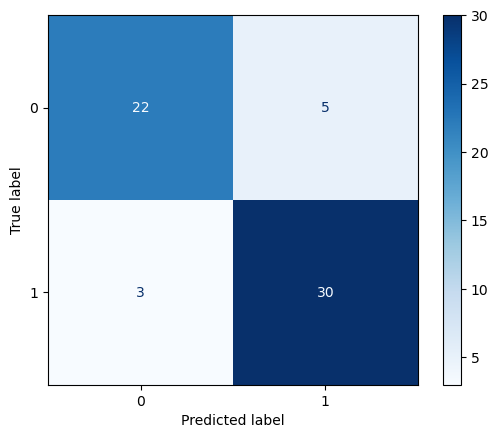

In [69]:
best_nb = grid_search_NB.best_estimator_
y_pred = best_nb.predict(X_test)  
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
print(classification_report(y_test, y_pred))

ROC-AUC: 0.9270482603815937


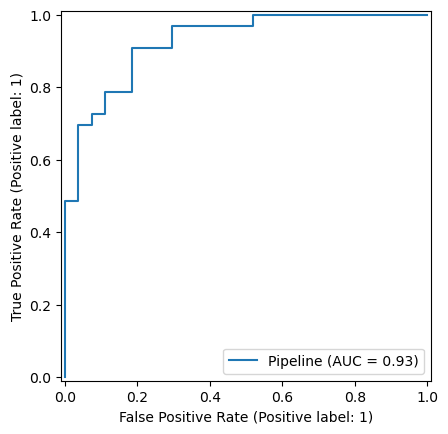

In [71]:
y_proba = best_nb.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)
RocCurveDisplay.from_estimator(best_nb, X_test, y_test)

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        27
           1       0.84      0.94      0.89        33

    accuracy                           0.87        60
   macro avg       0.88      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



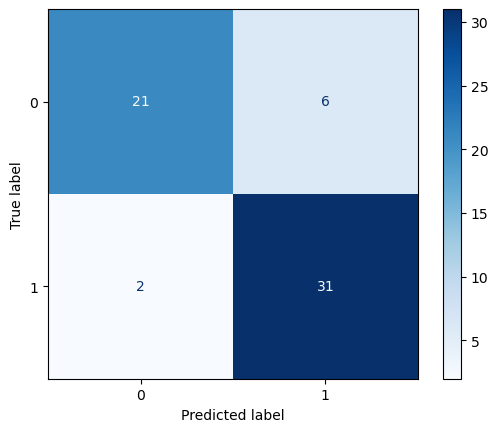

In [73]:
best_lr = grid_search_LR.best_estimator_
y_pred = best_lr.predict(X_test)  
cm_lr = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp.plot(cmap="Blues")
print(classification_report(y_test, y_pred))

ROC-AUC: 0.9461279461279462


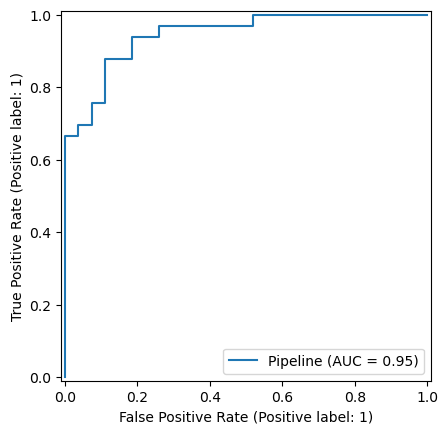

In [75]:
y_proba = best_lr.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)
RocCurveDisplay.from_estimator(best_lr, X_test, y_test)

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        27
           1       0.83      0.91      0.87        33

    accuracy                           0.85        60
   macro avg       0.85      0.84      0.85        60
weighted avg       0.85      0.85      0.85        60



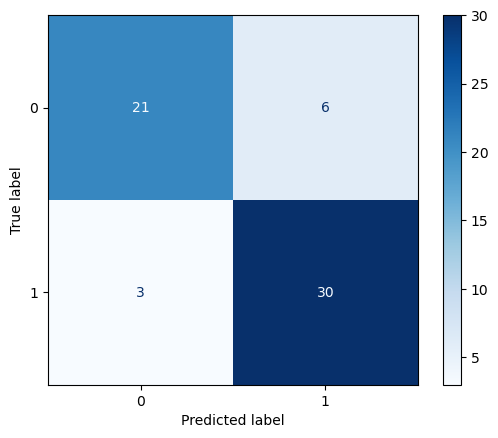

In [77]:
best_knn = grid_search_kNN.best_estimator_
y_pred = best_knn.predict(X_test)  
cm_knn = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot(cmap="Blues")
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8838383838383839


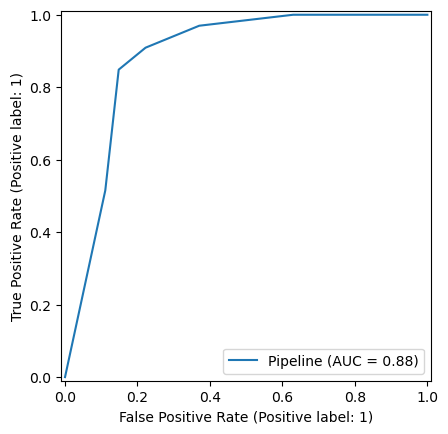

In [79]:
y_proba = best_knn.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)
RocCurveDisplay.from_estimator(best_knn, X_test, y_test)

              precision    recall  f1-score   support

           0       0.88      0.81      0.85        27
           1       0.86      0.91      0.88        33

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



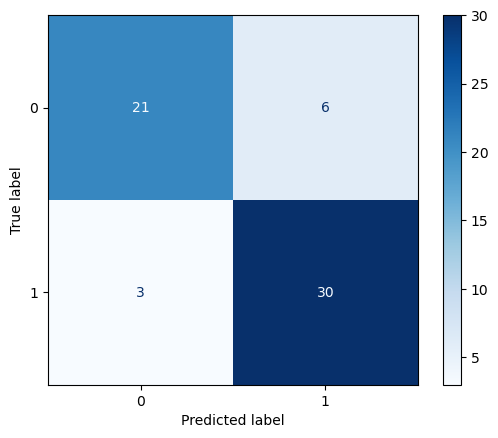

In [81]:
best_rf = grid_search_RF.best_estimator_
y_pred = best_rf.predict(X_test)  
cm_rf = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot(cmap="Blues")
print(classification_report(y_test, y_pred))

ROC-AUC: 0.9191919191919192


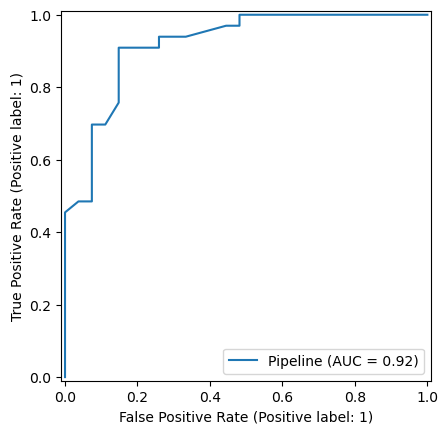

In [83]:
y_proba = best_rf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)